# Data preparation

In [1]:
#supress warning 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

#change the default number of rows to be displayed
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('max_info_columns', 1000)


In [2]:
#Please save this file and the dataset in your current working dictionary
os.getcwd()
data = pd.read_csv(os.path.join(os.getcwd(),'mortgages-in-ny-ne-clean.csv'))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063316 entries, 0 to 1063315
Data columns (total 101 columns):
Unnamed: 0                                  1063316 non-null int64
Unnamed: 0.1                                1063316 non-null int64
activity_year                               1063316 non-null int64
lei                                         1063316 non-null object
derived_msa_md                              1063316 non-null int64
state_code                                  1063316 non-null object
county_code                                 1057044 non-null float64
census_tract                                1056300 non-null float64
conforming_loan_limit                       1053335 non-null object
derived_loan_product_type                   1063316 non-null object
derived_dwelling_category                   1063316 non-null object
derived_ethnicity                           1063316 non-null object
derived_race                                1063316 non-null object
deri

In [4]:
'''filter the subset of first-time home buyer. We have 4 criteria:
1. business_or_commercial_purpose = 2 (Not primarily for a business or commercial purpose)
2. loan_purpose = 1 (home purchase)
3. occupancy_type = 1 (Principal residence) 
4. action_taken: filler out incomplete transactions 4,5  (4-Application withdrawn by applicant, 5-File closed for incompleteness
'''
first_timeHB = data[(data['business_or_commercial_purpose'] == 2) & 
                    (data['loan_purpose'] == 1) &
                    (data['occupancy_type'] == 1) &
                    (data['action_taken'].isin([1,2,3,6,7,8]))]

In [5]:
'''select columns for analysis'''

first_timeHB = first_timeHB[['derived_ethnicity','derived_race','derived_sex','applicant_age','income','action_taken',
'property_value','loan_amount','interest_rate','loan_term','loan_type','loan_to_value_ratio','debt_to_income_ratio',
'denial_reason_1','state_code','ffiec_msa_md_median_family_income','total_loan_costs']]

In [6]:
first_timeHB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361506 entries, 0 to 1063315
Data columns (total 17 columns):
derived_ethnicity                    361506 non-null object
derived_race                         361506 non-null object
derived_sex                          361506 non-null object
applicant_age                        361506 non-null object
income                               323636 non-null float64
action_taken                         361506 non-null int64
property_value                       353147 non-null float64
loan_amount                          361506 non-null int64
interest_rate                        321435 non-null float64
loan_term                            360262 non-null float64
loan_type                            361506 non-null int64
loan_to_value_ratio                  276016 non-null float64
debt_to_income_ratio                 283129 non-null object
denial_reason_1                      361506 non-null int64
state_code                           361506 non

In [7]:
'''Dealing with missing value of some important columns.
for missing value in :
1.income(thousands) - replaced by ffiec_msa_md_median_family_income(FFIEC Median family income in dollars for the MSA/MD in which the tract is located)
2.loan_to_value_ratio - filled by average
3.interest_rate - filled by average
4.total_loan_costs - filled by average
5.loan_term - filled by average
6.property_value - filled by loan_amount / loan_to_value_ratio
7.debt_to_income_ratio - filled by NA (one option in its categories)
'''

income_null = first_timeHB['income'].isnull()
first_timeHB.loc[income_null,'income'] = first_timeHB['ffiec_msa_md_median_family_income']/1000

first_timeHB['loan_to_value_ratio'] = first_timeHB['loan_to_value_ratio'].fillna(first_timeHB['loan_to_value_ratio'].mean())
first_timeHB['interest_rate'] = first_timeHB['interest_rate'].fillna(first_timeHB['interest_rate'].mean())
first_timeHB['total_loan_costs'] = first_timeHB['total_loan_costs'].fillna(first_timeHB['total_loan_costs'].mean())
first_timeHB['loan_term'] = first_timeHB['loan_term'].fillna(first_timeHB['loan_term'].mean())

property_null = first_timeHB['property_value'].isnull()
first_timeHB.loc[property_null,'property_value'] = first_timeHB['loan_amount']/first_timeHB['loan_to_value_ratio']

first_timeHB['debt_to_income_ratio'] = first_timeHB['debt_to_income_ratio'].replace(np.nan, "NA")

#change property_value units to thousands
first_timeHB['property_value'] = first_timeHB['property_value']/1000
first_timeHB['property_value'] = first_timeHB['property_value'].astype('int')
first_timeHB['loan_amount'] = first_timeHB['loan_amount']/1000
first_timeHB['loan_amount'] = first_timeHB['loan_amount'].astype('int')


In [8]:
first_timeHB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361506 entries, 0 to 1063315
Data columns (total 17 columns):
derived_ethnicity                    361506 non-null object
derived_race                         361506 non-null object
derived_sex                          361506 non-null object
applicant_age                        361506 non-null object
income                               361506 non-null float64
action_taken                         361506 non-null int64
property_value                       361506 non-null int64
loan_amount                          361506 non-null int64
interest_rate                        361506 non-null float64
loan_term                            361506 non-null float64
loan_type                            361506 non-null int64
loan_to_value_ratio                  361506 non-null float64
debt_to_income_ratio                 361506 non-null object
denial_reason_1                      361506 non-null int64
state_code                           361506 non-n

In [9]:
'''Explore age column, replace 8888 to unknown'''
first_timeHB.groupby('applicant_age')['income'].count().sort_values(ascending=False)


applicant_age
25-34    113107
35-44     89609
45-54     55432
8888      41818
55-64     32725
<25       13068
65-74     12930
>74        2817
Name: income, dtype: int64

In [10]:
first_timeHB['applicant_age'].replace({'8888':'Unknown'},inplace=True)

In [11]:
'''Explore income column, remove values less than 0 '''
first_timeHB['income'].describe()


count    361506.000000
mean        122.895346
std        1301.636721
min        -996.000000
25%          64.000000
50%          89.000000
75%         131.000000
max      771960.000000
Name: income, dtype: float64

In [12]:
first_timeHB = first_timeHB[first_timeHB['income'] > 0 ]

In [13]:
'''Explore loan_to_value_ratio column'''
first_timeHB['loan_to_value_ratio'].describe()

count    359977.000000
mean         84.570164
std         221.222517
min           0.380000
25%          80.000000
50%          84.563995
75%          95.000000
max       95000.000000
Name: loan_to_value_ratio, dtype: float64

In [14]:
'''remove value >100(%)'''
first_timeHB = first_timeHB[first_timeHB['loan_to_value_ratio'] <= 100 ]

In [15]:
first_timeHB['interest_rate'].describe()

count    352434.000000
mean          4.621292
std          11.100478
min           0.001000
25%           4.375000
50%           4.625000
75%           4.875000
max        4875.000000
Name: interest_rate, dtype: float64

In [16]:
'''remove value >100(%)'''
first_timeHB = first_timeHB[first_timeHB['interest_rate'] <= 100 ]

In [17]:
'''The category in debt_to_income_ratio is messy. Next, try to create a new column to arrange data'''
first_timeHB['debt_to_income_ratio'].unique()

array(['41', '30%-<36%', '45', '>60%', '47', '39', '48', '44', '37',
       '20%-<30%', '50%-60%', '42', '43', '46', '49', '36', '40', '38',
       '<20%', 'NA', 'Exempt'], dtype=object)

In [18]:
'''create new range for debt_to_income_ratio
[<20%,20%-<30%,30%-<40%, 40%-<50%,50%-60%, >60%]
warning: take some time to run! (arounds 1 mins)'''


r1 = ['30%-<36%','36', '37','38','39']
r2 = ['40','41','42','43','44','45','46','47','48','49']
r3 = ['NA','20%-<30%','<20%','50%-60%','>60%','Exempt']

first_timeHB['new_debt_to_income_ratio'] = '0'
index1=first_timeHB.columns.get_loc('debt_to_income_ratio')

def new_cat(data):
    if data['debt_to_income_ratio'] in r1:
        return '30%-<40%'
    elif data['debt_to_income_ratio'] in r2:
        return '40%-<50%'
    elif data['debt_to_income_ratio'] in r3:
        return data['debt_to_income_ratio']


first_timeHB['new_debt_to_income_ratio'] = first_timeHB.apply(new_cat, axis=1)
first_timeHB['new_debt_to_income_ratio'] = first_timeHB['new_debt_to_income_ratio'].astype('category')


In [19]:
'''Add new column: approve to indicates whether the application approved or not
   warning: take some time to run! (arounds 1 mins)'''
def approve(data):
    if data['denial_reason_1'] == 10:
        return 'Approve'
    else:
        return 'Reject'
first_timeHB['approve'] = first_timeHB.apply(approve, axis=1)
first_timeHB['approve'] = first_timeHB['approve'].astype('category')


In [20]:
first_timeHB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352430 entries, 0 to 1063314
Data columns (total 19 columns):
derived_ethnicity                    352430 non-null object
derived_race                         352430 non-null object
derived_sex                          352430 non-null object
applicant_age                        352430 non-null object
income                               352430 non-null float64
action_taken                         352430 non-null int64
property_value                       352430 non-null int64
loan_amount                          352430 non-null int64
interest_rate                        352430 non-null float64
loan_term                            352430 non-null float64
loan_type                            352430 non-null int64
loan_to_value_ratio                  352430 non-null float64
debt_to_income_ratio                 352430 non-null object
denial_reason_1                      352430 non-null int64
state_code                           352430 non-n

In [21]:
# replace values to string on action_taken, denial_reason_1, and loan_type:

first_timeHB['action_taken'] = first_timeHB['action_taken'].replace(to_replace=1,value ="Loan originated")
first_timeHB['action_taken'] = first_timeHB['action_taken'].replace(to_replace=2,value ="Application approved but not accepted" )
first_timeHB['action_taken'] = first_timeHB['action_taken'].replace(to_replace=3,value ="Application denied")
first_timeHB['action_taken'] = first_timeHB['action_taken'].replace(to_replace=6,value ="Purchased loan")
first_timeHB['action_taken'] = first_timeHB['action_taken'].replace(to_replace=7,value ="Preapproval request denied")
first_timeHB['action_taken'] = first_timeHB['action_taken'].replace(to_replace=8,value ="Preapproval request approved but not accepted")

first_timeHB['denial_reason_1'] = first_timeHB['denial_reason_1'].replace(to_replace=1,value ="Debt-to-income ratio")
first_timeHB['denial_reason_1'] = first_timeHB['denial_reason_1'].replace(to_replace=2,value ="Employment history" )
first_timeHB['denial_reason_1'] = first_timeHB['denial_reason_1'].replace(to_replace=3,value ="Credit history")
first_timeHB['denial_reason_1'] = first_timeHB['denial_reason_1'].replace(to_replace=4,value ="Collateral")
first_timeHB['denial_reason_1'] = first_timeHB['denial_reason_1'].replace(to_replace=5,value ="Insufficient cash")
first_timeHB['denial_reason_1'] = first_timeHB['denial_reason_1'].replace(to_replace=6,value ="Unverifiable information")
first_timeHB['denial_reason_1'] = first_timeHB['denial_reason_1'].replace(to_replace=7,value ="Credit application incomplete")
first_timeHB['denial_reason_1'] = first_timeHB['denial_reason_1'].replace(to_replace=8,value ="Mortgage insurance denied")
first_timeHB['denial_reason_1'] = first_timeHB['denial_reason_1'].replace(to_replace=9,value ="Other")
first_timeHB['denial_reason_1'] = first_timeHB['denial_reason_1'].replace(to_replace=10,value ="Not applicable")

first_timeHB['loan_type'] = first_timeHB['loan_type'].replace(to_replace=1,value ="Conventional (not insured or guaranteed by FHA, VA, RHS, or FSA)")
first_timeHB['loan_type'] = first_timeHB['loan_type'].replace(to_replace=2,value ="Federal Housing Administration insured (FHA)" )
first_timeHB['loan_type'] = first_timeHB['loan_type'].replace(to_replace=3,value ="Veterans Affairs guaranteed (VA)")
first_timeHB['loan_type'] = first_timeHB['loan_type'].replace(to_replace=4,value ="USDA Rural Housing Service or Farm Service Agency guaranteed (RHS or FSA)")

# Overview of Application

In [22]:
# Figure 1. Numerical summary of loan information   

print('Mean Income(in thousands): ',np.mean(first_timeHB['income']))
print('Mean Property Value(in thousands): ',np.mean(first_timeHB['property_value']))
print('Mean Loan Amount(in thousands): ',np.mean(first_timeHB['loan_amount']))
print('Mean Total Loan Costs(in thousands): ',np.mean(first_timeHB['total_loan_costs']))
print('Mean Loan Term: ',np.mean(first_timeHB['loan_term']))
print('Mean Interest Rate: ',np.mean(first_timeHB['interest_rate']))


Mean Income(in thousands):  124.57478960361466
Mean Property Value(in thousands):  416.54849473654343
Mean Loan Amount(in thousands):  324.4551542150214
Mean Total Loan Costs(in thousands):  5532.067072545499
Mean Loan Term:  347.4477917880959
Mean Interest Rate:  4.592334615513972


In [23]:
# Figure 2. Percentage summary table of loan type

table_loan_type = first_timeHB.groupby('loan_type')['loan_type'].count()
table_loan_type_percent = 100 * table_loan_type / table_loan_type.sum()
table_loan_type_percent


loan_type
Conventional (not insured or guaranteed by FHA, VA, RHS, or FSA)             73.149562
Federal Housing Administration insured (FHA)                                 20.153222
USDA Rural Housing Service or Farm Service Agency guaranteed (RHS or FSA)     1.339273
Veterans Affairs guaranteed (VA)                                              5.357943
Name: loan_type, dtype: float64

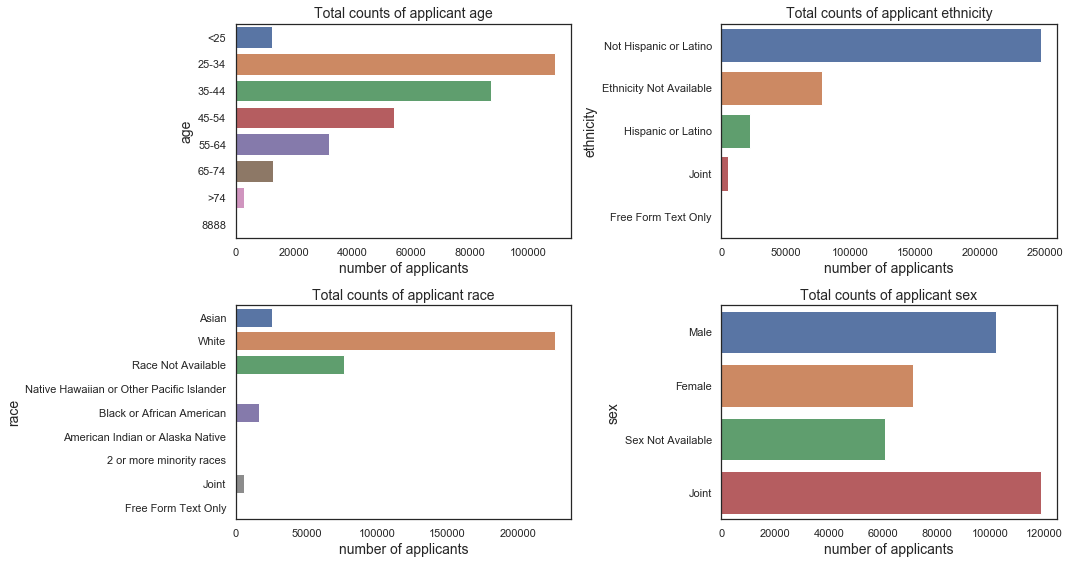

In [24]:
# Figure 3. Bar charts of geographical information of applicants

# set the style and size of the seaborn plots
sns.set(style="white")
plt.figure(figsize=(15,8))

#plot age
plt.subplot(2,2,1)
ax = sns.countplot(y="applicant_age", data=first_timeHB,order=['<25','25-34','35-44','45-54','55-64','65-74','>74','8888'] )
plt.xlabel('number of applicants',fontsize=14)
plt.ylabel('age',fontsize=14)
plt.title('Total counts of applicant age',fontsize=14)

#plot ethnicity
plt.subplot(2,2,2)
ax = sns.countplot(y="derived_ethnicity", data=first_timeHB )
plt.xlabel('number of applicants',fontsize=14)
plt.ylabel('ethnicity',fontsize=14)
plt.title('Total counts of applicant ethnicity',fontsize=14)

#plot race
plt.subplot(2,2,3)
ax = sns.countplot(y="derived_race", data=first_timeHB )
plt.xlabel('number of applicants',fontsize=14)
plt.ylabel('race',fontsize=14)
plt.title('Total counts of applicant race',fontsize=14)

#plor sex
plt.subplot(2,2,4)
ax = sns.countplot(y="derived_sex", data=first_timeHB )
plt.xlabel('number of applicants',fontsize=14)
plt.ylabel('sex',fontsize=14)
plt.title('Total counts of applicant sex',fontsize=14)

#show plots
plt.tight_layout()
plt.show()

# K-means Clustering

In [25]:
"""   normalize data  """ 

#import normalize package
from sklearn.preprocessing import normalize
from sklearn import preprocessing

#select data to be normalized by variables:
first_timeHB['approve'] = first_timeHB['approve'].replace(to_replace="Approve",value =1)
first_timeHB['approve'] = first_timeHB['approve'].replace(to_replace="Reject",value =0)
dataset = first_timeHB[['income','property_value','loan_amount','approve']]

data_scaled = normalize(dataset)
data_scaled = pd.DataFrame(data_scaled, columns=dataset.columns)
data_scaled.head()

,income,property_value,loan_amount,approve
0,0.170462,0.740163,0.650447,0.004486
1,0.204282,0.770701,0.603561,0.001857
2,0.113518,0.721511,0.683031,0.001924
3,0.079282,0.719410,0.690046,0.000000
4,0.239455,0.741172,0.627145,0.003801


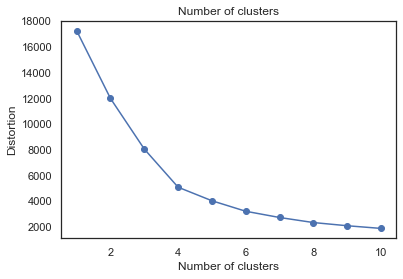

In [26]:
""" use elbow method to find k-value / number of clusters 
    code running of 3 mins
"""

# Figure 4.  Number of clusters by elbow method 

from sklearn.cluster import KMeans

# calculate distortion for a range of number of cluster

distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=4000,
        tol=1e-04, random_state=0
    )
    km.fit(data_scaled)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title ('Number of clusters')
plt.show()

In [27]:
""" use k-means method to perform clustering for dataset,
"""

from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(data_scaled)
# Getting the cluster labels
labels = kmeans.predict(data_scaled)

df_labels = pd.DataFrame(data=labels)
df_labels.columns = ['labels']

first_timeHB_clustered = pd.concat([first_timeHB, df_labels], axis=1)
first_timeHB_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589705 entries, 0 to 1063314
Data columns (total 20 columns):
derived_ethnicity                    352430 non-null object
derived_race                         352430 non-null object
derived_sex                          352430 non-null object
applicant_age                        352430 non-null object
income                               352430 non-null float64
action_taken                         352430 non-null object
property_value                       352430 non-null float64
loan_amount                          352430 non-null float64
interest_rate                        352430 non-null float64
loan_term                            352430 non-null float64
loan_type                            352430 non-null object
loan_to_value_ratio                  352430 non-null float64
debt_to_income_ratio                 352430 non-null object
denial_reason_1                      352430 non-null object
state_code                           35243

In [28]:
# Figure 5. Classification of applicants by k-means method

table_cluster = first_timeHB_clustered.groupby('labels')['income','loan_amount','property_value'].mean()
table_cluster['loan_to_income_ratio']= table_cluster['loan_amount'] / table_cluster['income']
table_cluster['property_to_income_ratio'] = table_cluster['property_value'] / table_cluster['income']
table_cluster['approve_rate'] = np.sum(first_timeHB_clustered.groupby('labels')['approve']) /first_timeHB_clustered.groupby('labels')['approve'].count() 
table_cluster # show table

,income,loan_amount,property_value,loan_to_income_ratio,property_to_income_ratio,approve_rate
labels,,,,,,
0.0,119.779017,307.129518,396.496834,2.564135,3.310236,0.899094
1.0,124.792309,299.430920,385.944556,2.399434,3.092695,0.900281
2.0,104.246630,278.304969,347.684139,2.669678,3.335207,0.886317


# Clustering analysis by age and race

In [29]:
"""prepare data for comparison analysis between clustered groups
"""
#filter data by clustered groups and store into 3 dataframe 
group_1 = first_timeHB_clustered[first_timeHB_clustered['labels']==0]
group_2 = first_timeHB_clustered[first_timeHB_clustered['labels']==1]
group_3 = first_timeHB_clustered[first_timeHB_clustered['labels']==2]

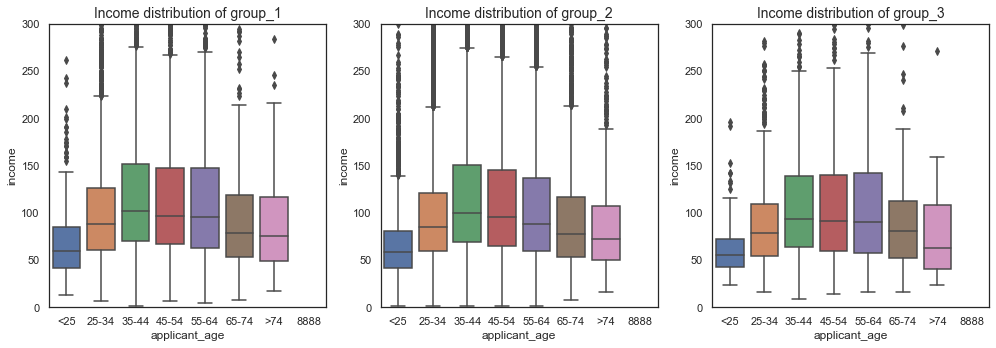

In [30]:
# Figure 6.  Boxplots of income distribution by age

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
sns.boxplot(x='applicant_age', y='income',data = group_1, 
            order = ['<25','25-34','35-44','45-54','55-64','65-74','>74','8888'])
plt.ylim(0,300)
plt.title("Income distribution of group_1",fontsize=14)

plt.subplot(1,3,2)
sns.boxplot(x='applicant_age', y='income',data = group_2, 
            order = ['<25','25-34','35-44','45-54','55-64','65-74','>74','8888'])
plt.ylim(0,300)
plt.title("Income distribution of group_2",fontsize=14)

plt.subplot(1,3,3)
sns.boxplot(x='applicant_age', y='income',data = group_3, 
            order = ['<25','25-34','35-44','45-54','55-64','65-74','>74','8888'])
plt.ylim(0,300)
plt.title("Income distribution of group_3",fontsize=14)


plt.tight_layout()
plt.show()

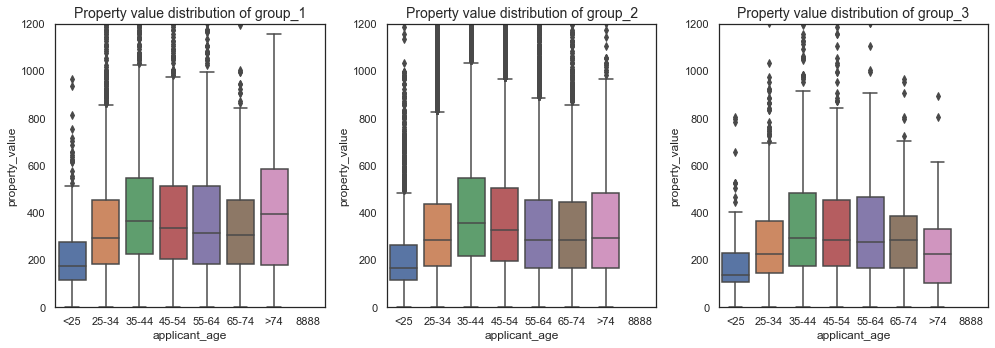

In [31]:
# Figure 7. Boxplots of property value distribution by age

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
sns.boxplot(x='applicant_age', y='property_value',data = group_1, 
            order = ['<25','25-34','35-44','45-54','55-64','65-74','>74','8888'])
plt.ylim(0,1200)
plt.title('Property value distribution of group_1',fontsize=14)

plt.subplot(1,3,2)
sns.boxplot(x='applicant_age', y='property_value',data = group_2, 
            order = ['<25','25-34','35-44','45-54','55-64','65-74','>74','8888'])
plt.ylim(0,1200)
plt.title('Property value distribution of group_2',fontsize=14)

plt.subplot(1,3,3)
sns.boxplot(x='applicant_age', y='property_value',data = group_3, 
            order = ['<25','25-34','35-44','45-54','55-64','65-74','>74','8888'])
plt.ylim(0,1200)
plt.title('Property value distribution of group_3',fontsize=14)

plt.tight_layout()
plt.show()

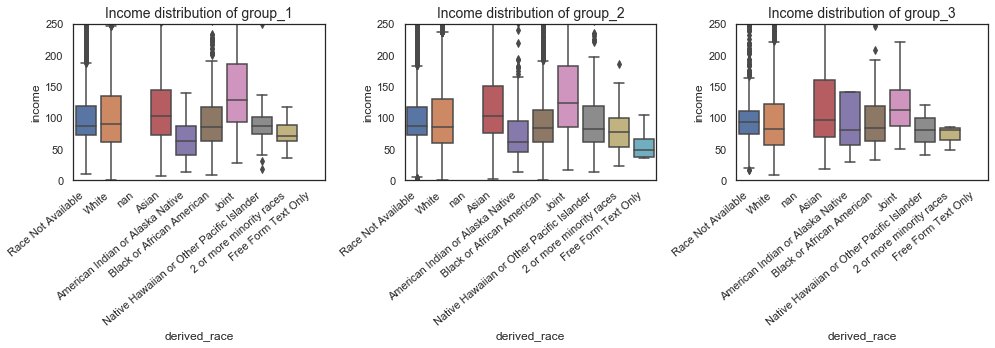

In [32]:
# Figure 8. Box plots of income distribution by race

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
sns.boxplot(x='derived_race', y='income',data = group_1,
           order = ['Race Not Available', 'White', 'nan', 'Asian',
       'American Indian or Alaska Native', 'Black or African American',
       'Joint', 'Native Hawaiian or Other Pacific Islander',
       '2 or more minority races', 'Free Form Text Only'])
plt.ylim(0,250)
plt.title("Income distribution of group_1",fontsize=14)
plt.setp(plt.gca().get_xticklabels(), rotation=40, horizontalalignment='right')

plt.subplot(1,3,2)
sns.boxplot(x='derived_race', y='income',data = group_2,
                      order = ['Race Not Available', 'White', 'nan', 'Asian',
       'American Indian or Alaska Native', 'Black or African American',
       'Joint', 'Native Hawaiian or Other Pacific Islander',
       '2 or more minority races', 'Free Form Text Only'])
plt.ylim(0,250)
plt.title("Income distribution of group_2",fontsize=14)
plt.setp(plt.gca().get_xticklabels(), rotation=40, horizontalalignment='right')

plt.subplot(1,3,3)
sns.boxplot(x='derived_race', y='income',data = group_3,
                      order = ['Race Not Available', 'White', 'nan', 'Asian',
       'American Indian or Alaska Native', 'Black or African American',
       'Joint', 'Native Hawaiian or Other Pacific Islander',
       '2 or more minority races', 'Free Form Text Only'])
plt.ylim(0,250)
plt.title("Income distribution of group_3",fontsize=14)
plt.setp(plt.gca().get_xticklabels(), rotation=40, horizontalalignment='right')


plt.tight_layout()
plt.show()

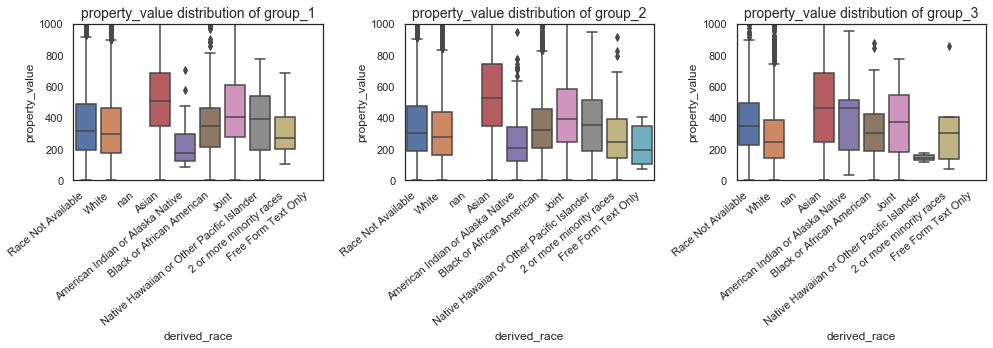

In [33]:
# Figure 9. Box plots of property value distribution by race

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
sns.boxplot(x='derived_race', y='property_value',data = group_1,
           order = ['Race Not Available', 'White', 'nan', 'Asian',
       'American Indian or Alaska Native', 'Black or African American',
       'Joint', 'Native Hawaiian or Other Pacific Islander',
       '2 or more minority races', 'Free Form Text Only'])
plt.ylim(0,1000)
plt.title("property_value distribution of group_1",fontsize=14)
plt.setp(plt.gca().get_xticklabels(), rotation=40, horizontalalignment='right')

plt.subplot(1,3,2)
sns.boxplot(x='derived_race', y='property_value',data = group_2,
                      order = ['Race Not Available', 'White', 'nan', 'Asian',
       'American Indian or Alaska Native', 'Black or African American',
       'Joint', 'Native Hawaiian or Other Pacific Islander',
       '2 or more minority races', 'Free Form Text Only'])
plt.ylim(0,1000)
plt.title("property_value distribution of group_2",fontsize=14)
plt.setp(plt.gca().get_xticklabels(), rotation=40, horizontalalignment='right')

plt.subplot(1,3,3)
sns.boxplot(x='derived_race', y='property_value',data = group_3,
                      order = ['Race Not Available', 'White', 'nan', 'Asian',
       'American Indian or Alaska Native', 'Black or African American',
       'Joint', 'Native Hawaiian or Other Pacific Islander',
       '2 or more minority races', 'Free Form Text Only'])
plt.ylim(0,1000)
plt.title("property_value distribution of group_3",fontsize=14)
plt.setp(plt.gca().get_xticklabels(), rotation=40, horizontalalignment='right')


plt.tight_layout()
plt.show()

# Overview of Denial reason

In [34]:
"""preprare data for denial reason analysis
"""
# filter and store denail data in each group
denial_group_1= group_1[group_1['denial_reason_1']!="Not applicable"]
denial_group_2= group_2[group_2['denial_reason_1']!="Not applicable"]
denial_group_3= group_3[group_3['denial_reason_1']!="Not applicable"]

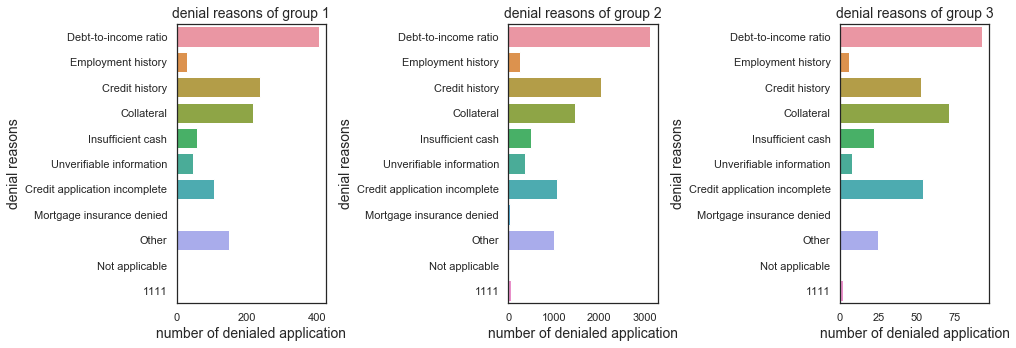

In [35]:
# Figure 10. Bar charts of denial reason in each group

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
ax = sns.countplot(y="denial_reason_1", data=denial_group_1,
                   order=['Debt-to-income ratio','Employment history',
                         'Credit history','Collateral','Insufficient cash',
                         'Unverifiable information','Credit application incomplete',
                         'Mortgage insurance denied','Other','Not applicable',1111,])
plt.xlabel('number of denialed application',fontsize=14)
plt.ylabel('denial reasons',fontsize=14)
plt.title('denial reasons of group 1',fontsize=14)

plt.subplot(1,3,2)
ax = sns.countplot(y="denial_reason_1", data=denial_group_2, 
                   order=['Debt-to-income ratio','Employment history',
                         'Credit history','Collateral','Insufficient cash',
                         'Unverifiable information','Credit application incomplete',
                         'Mortgage insurance denied','Other','Not applicable',1111,]) 
plt.xlabel('number of denialed application',fontsize=14)
plt.ylabel('denial reasons',fontsize=14)
plt.title('denial reasons of group 2',fontsize=14)

plt.subplot(1,3,3)
ax = sns.countplot(y="denial_reason_1", data=denial_group_3, 
                   order=['Debt-to-income ratio','Employment history',
                         'Credit history','Collateral','Insufficient cash',
                         'Unverifiable information','Credit application incomplete',
                         'Mortgage insurance denied','Other','Not applicable',1111,]) 
plt.xlabel('number of denialed application',fontsize=14)
plt.ylabel('denial reasons',fontsize=14)
plt.title('denial reasons of group 3',fontsize=14)


plt.tight_layout()
plt.show()

# Analysis of debt to income ratio

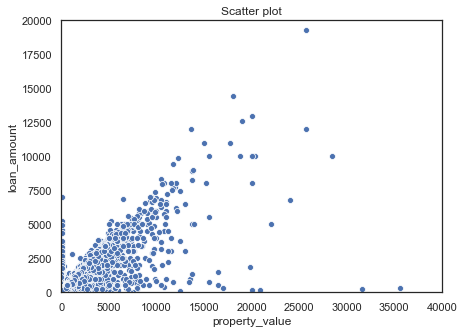

In [36]:
# Figure 11. scatter plot for loan amount and property value

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
_ = sns.scatterplot(y='loan_amount', x='property_value', data=first_timeHB_clustered)             
plt.ylim(0,20000)
plt.xlim(0,40000)
plt.title('Scatter plot')

plt.show()

<Figure size 1440x216 with 0 Axes>

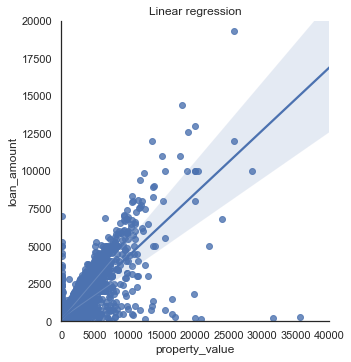

In [37]:
# Figure 12. simple linear regression plot for loan amount and property value

plt.figure(figsize=(20,3))

_ = sns.lmplot(y='loan_amount', x='property_value', data=first_timeHB_clustered)
plt.ylim(0,20000)
plt.xlim(0,40000)
plt.title('Linear regression')

plt.show()

In [38]:
"""prepare data for comparison analysis between approval and reject applicants
"""
# filter and store approved and rejection data by denial reason
approved = first_timeHB[first_timeHB['denial_reason_1']=="Not applicable"]
rejection = first_timeHB[first_timeHB['denial_reason_1']!="Not applicable"]

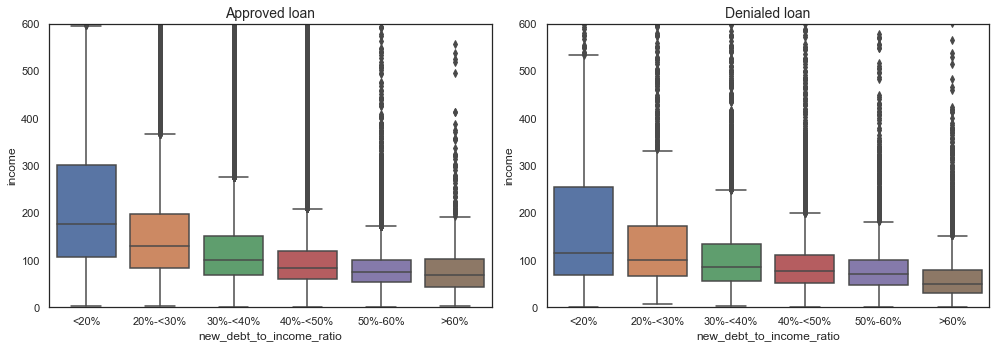

In [39]:
# Figure 13. Comparison of income against debt to income ratio between approval and denial 

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.boxplot(y='income',x='new_debt_to_income_ratio', data = approved,
           order = ['<20%','20%-<30%','30%-<40%', '40%-<50%','50%-60%', '>60%'])
plt.ylim(0,600)
plt.title('Approved loan',fontsize=14)

plt.subplot(1,2,2)
sns.boxplot(y='income',x='new_debt_to_income_ratio', data = rejection,
           order = ['<20%','20%-<30%','30%-<40%', '40%-<50%','50%-60%', '>60%'])
plt.ylim(0,600)
plt.title('Denialed loan',fontsize=14)

plt.tight_layout()
plt.show()

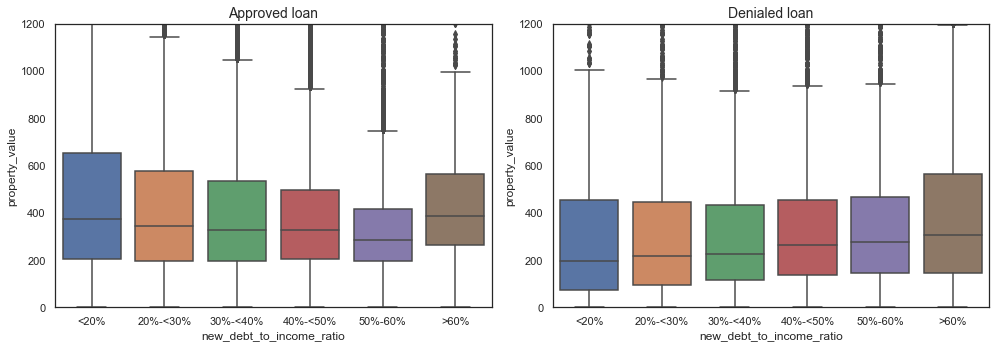

In [40]:
# Figure 14. Comparison of property value against debt to income ratio between approval and denial

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.boxplot(y='property_value',x='new_debt_to_income_ratio', data = approved,
           order = ['<20%','20%-<30%','30%-<40%', '40%-<50%','50%-60%', '>60%'])
plt.ylim(0,1200)
plt.title('Approved loan',fontsize=14)

plt.subplot(1,2,2)
sns.boxplot(y='property_value',x='new_debt_to_income_ratio', data = rejection,
           order = ['<20%','20%-<30%','30%-<40%', '40%-<50%','50%-60%', '>60%'])
plt.ylim(0,1200)
plt.title('Denialed loan',fontsize=14)


plt.tight_layout()
plt.show()

In [41]:
# Figure 15. Summary table of mortgage ratio with approve rate by age

table_age = first_timeHB.groupby('applicant_age')['income','loan_amount','property_value'].mean()
table_age['loan_to_income_ratio']= table_age['loan_amount'] / table_age['income']
table_age['property_to_income_ratio'] = table_age['property_value'] / table_age['income']
table_age['approve_rate'] = np.sum(first_timeHB.groupby('applicant_age')['approve']) /first_timeHB.groupby('applicant_age')['approve'].count() 
table_age.sort_values(by='approve_rate')
table_age


,income,loan_amount,property_value,loan_to_income_ratio,property_to_income_ratio,approve_rate
applicant_age,,,,,,
25-34,108.627998,300.741107,370.398350,2.768541,3.409787,0.921603
35-44,143.998000,380.962746,498.469201,2.645611,3.461640,0.905469
45-54,141.622462,340.917452,470.464931,2.407227,3.321965,0.878892
55-64,135.175155,284.478704,422.307336,2.104519,3.124149,0.868347
65-74,109.825973,249.083012,396.348479,2.267979,3.608877,0.871787
<25,139.793231,195.934013,230.311499,1.401599,1.647515,0.877729
>74,125.269181,251.773728,433.995309,2.009862,3.464502,0.835799
Unknown,95.341832,343.208980,351.546588,3.599773,3.687223,0.998397


In [42]:
# Figure 16. Summary table of mortgage ratio with approve rate by race 

table_race = first_timeHB.groupby('derived_race')['income','loan_amount','property_value'].mean()
table_race['loan_to_income_ratio']= table_race['loan_amount'] / table_race['income']
table_race['property_to_income_ratio'] = table_race['property_value'] / table_race['income']
table_race['approve_rate'] = np.sum(first_timeHB.groupby('derived_race')['approve']) /first_timeHB.groupby('derived_race')['approve'].count() 
table_age.sort_values(by='approve_rate',ascending=False)
table_race


,income,loan_amount,property_value,loan_to_income_ratio,property_to_income_ratio,approve_rate
derived_race,,,,,,
2 or more minority races,94.436490,291.044568,382.100279,3.081908,4.046108,0.738162
American Indian or Alaska Native,95.045324,231.834532,310.374101,2.439200,3.265538,0.722302
Asian,131.474539,420.880750,607.002491,3.201234,4.616882,0.893438
Black or African American,98.419395,315.766504,360.636491,3.208377,3.664283,0.826711
Free Form Text Only,116.692308,312.307692,513.076923,2.676335,4.396836,0.653846
Joint,168.975553,424.461422,560.716360,2.511969,3.318328,0.916090
Native Hawaiian or Other Pacific Islander,94.753898,289.762712,395.550847,3.058056,4.174507,0.769492
Race Not Available,121.887591,356.631701,421.824959,2.925907,3.460770,0.939642
White,125.649804,301.008556,393.802177,2.395615,3.134125,0.910963


# Analysis of credit history

In [43]:
# Figure 17. Summary table of comparison between approval and denied for credit by age

# get denial applicants for credit history
credit_history = first_timeHB[first_timeHB['denial_reason_1']=='Credit history']

# build dataframe of credit history by key values
table_credit = credit_history.groupby('applicant_age')['income','loan_amount','property_value'].mean()
table_credit['loan_to_income_ratio']= table_credit['loan_amount'] / table_credit['income']
table_credit['property_to_income_ratio'] = table_credit['property_value'] / table_credit['income']
table_credit.sort_values(by='loan_amount')

# build dataframe of approved data by key values
table_approved = approved.groupby('applicant_age')['income','loan_amount','property_value'].mean()
table_approved['loan_to_income_ratio']= table_approved['loan_amount'] / table_approved['income']
table_approved['property_to_income_ratio'] = table_approved['property_value'] / table_approved['income']
table_approved['age']=table_approved.index
table_approved.sort_values(by='loan_amount')

# build dataframe combined approved data and credit hitory
combined_table_credit = pd.DataFrame(table_approved['age'])
combined_table_credit['approved income'] =table_approved['income']
combined_table_credit['credit income'] =table_credit['income']
combined_table_credit['approved loan'] =table_approved['loan_amount']
combined_table_credit['credit loan'] =table_credit['loan_amount']
combined_table_credit['approved property_value'] =table_approved['property_value']
combined_table_credit['credit property_value'] =table_credit['property_value']
combined_table_credit['approved loan_to_income'] =table_approved['loan_to_income_ratio']
combined_table_credit['credit loan_to_income'] =table_credit['loan_to_income_ratio']
combined_table_credit['approved property_to_income'] =table_approved['property_to_income_ratio']
combined_table_credit['credit property_to_income'] =table_credit['property_to_income_ratio']
combined_table_credit = combined_table_credit.drop(['age'],axis = 1)
combined_table_credit

,approved income,credit income,approved loan,credit loan,approved property_value,credit property_value,approved loan_to_income,credit loan_to_income,approved property_to_income,credit property_to_income
applicant_age,,,,,,,,,,
25-34,110.178400,78.965046,303.466928,180.489635,375.420032,205.987134,2.754323,2.285690,3.407383,2.608586
35-44,146.898618,97.482734,385.524840,220.000000,506.415288,269.612965,2.624428,2.256810,3.447380,2.765751
45-54,145.559695,99.976512,345.873466,213.663854,477.260905,275.468354,2.376162,2.137141,3.278798,2.755331
55-64,140.457858,92.397521,290.337439,170.878099,424.458153,387.924587,2.067079,1.849380,3.021961,4.198431
65-74,113.095600,81.350161,253.199279,153.585209,399.115149,240.475884,2.238808,1.887952,3.529007,2.956059
<25,79.310761,2650.771477,199.008660,135.167785,235.730238,133.808725,2.509226,0.050992,2.972235,0.050479
>74,103.744991,83.413333,248.186528,178.222222,408.056563,363.266667,2.392275,2.136616,3.933265,4.355019
Unknown,95.322374,48.000000,343.184301,127.500000,351.437823,80.500000,3.600249,2.656250,3.686835,1.677083


In [44]:
# Figure 18. Summary table of comparison between approval and denied for credit by age

# get denial applicants for credit history
table_credit = credit_history.groupby('derived_race')['income','loan_amount','property_value'].mean()
table_credit['loan_to_income']= table_credit['loan_amount'] / table_credit['income']
table_credit['property_to_income'] = table_credit['property_value'] / table_credit['income']

# build dataframe of approved data by key values
table_approved = approved.groupby('derived_race')['income','loan_amount','property_value'].mean()
table_approved['loan_to_income']= table_approved['loan_amount'] / table_approved['income']
table_approved['property_to_income'] = table_approved['property_value'] / table_approved['income']
table_approved['race']=table_approved.index

# build dataframe combined approved data and credit hitory
combined_table_credit = pd.DataFrame(table_approved['race'])
combined_table_credit['approved income'] =table_approved['income']
combined_table_credit['credit income'] =table_credit['income']
combined_table_credit['approved loan'] =table_approved['loan_amount']
combined_table_credit['credit loan'] =table_credit['loan_amount']
combined_table_credit['approved property'] =table_approved['property_value']
combined_table_credit['credit property'] =table_credit['property_value']
combined_table_credit['approved loan_to_income'] =table_approved['loan_to_income']
combined_table_credit['credit loan_to_income'] =table_credit['loan_to_income']
combined_table_credit['approved property_to_income'] =table_approved['property_to_income']
combined_table_credit['credit property_to_income'] =table_credit['property_to_income']
combined_table_credit = combined_table_credit.drop(['race'],axis = 1)
combined_table_credit

,approved income,credit income,approved loan,credit loan,approved property,credit property,approved loan_to_income,credit loan_to_income,approved property_to_income,credit property_to_income
derived_race,,,,,,,,,,
2 or more minority races,102.092075,60.150000,311.339623,121.818182,371.026415,196.500000,3.049596,2.025240,3.634233,3.266833
American Indian or Alaska Native,99.119323,97.148148,248.386454,166.666667,306.525896,283.740741,2.505934,1.715593,3.092494,2.920701
Asian,133.309701,145.144406,422.522216,329.440559,607.650854,551.027972,3.169478,2.269743,4.558189,3.796412
Black or African American,101.069516,87.834741,322.305730,244.040307,366.319778,321.404990,3.188951,2.778403,3.624434,3.659201
Free Form Text Only,119.705882,139.250000,362.058824,155.000000,487.941176,525.000000,3.024570,1.113106,4.076167,3.770197
Joint,171.897254,124.038095,431.131589,222.904762,570.878548,298.790476,2.508077,1.797067,3.321045,2.408861
Native Hawaiian or Other Pacific Islander,100.395815,79.269231,309.911894,171.538462,397.061674,365.076923,3.086901,2.163998,3.954962,4.605531
Race Not Available,121.386910,94.726447,358.575510,228.039474,420.047608,294.560526,2.953988,2.407347,3.460403,3.109591
White,124.532937,265.779494,305.200908,171.877341,399.410956,236.801732,2.450765,0.646692,3.207272,0.890971


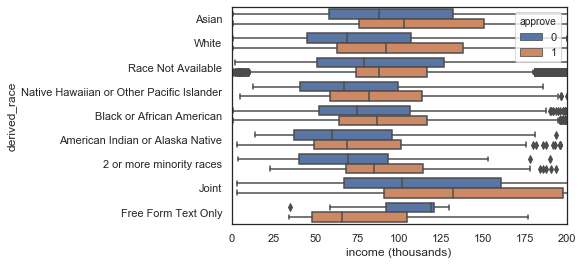

In [45]:
sns.boxplot(x='income',y='derived_race', hue='approve', data = first_timeHB)
plt.xlabel('income (thousands)')
plt.xlim(0,200)
plt.show()

# Hypothesis Test

## Null Hypothesis: The total loan costs of white and native have the identical probability distribution

In [46]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))
    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)
    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates
        

def diff_of_means(data_1, data_2):
    diff = np.mean(data_1)-np.mean(data_2)

    return diff

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

In [47]:
#Extract total loan costs of white and black
costofwhite = first_timeHB.loc[(first_timeHB['derived_race']=='White','total_loan_costs')]
costofnative = first_timeHB.loc[(first_timeHB['derived_race']=='Native Hawaiian or Other Pacific Islander','total_loan_costs')]


In [48]:
mean_diff = np.mean(costofnative) - np.mean(costofwhite)
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((costofwhite, costofnative)))

# Shift the samples
costofwhite_shifted = costofwhite - np.mean(costofwhite) + combined_mean
costofnative_shifted = costofnative - np.mean(costofnative) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_costofwhite = draw_bs_reps(costofwhite_shifted,np.mean,10000)
bs_costofnative = draw_bs_reps(costofnative_shifted,np.mean,10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_costofnative - bs_costofwhite

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.0


### P value is 0.We reject the null hypothesis. The total loan costs of white and native do not have the identical distribution.

# Logistic Regression: whether the loan is approved or not determined by what factors?

### From the previous analysis, we have a basic ideas that income,loan amount and race might have influence on the approval of loan. Thus, we will perform a logistic regression and do cross validation to see the predict power of this regression.
### Predict variable (desired target):
### y — approved or rejected? (binary: “1”, means “approved”, “0” means "rejected”)
### Predictors: loan amount,debt to income ratio(dummy variables),race(dummy variables)

In [49]:
#create a new dataframe to only keep our interested columns and drop meaningless rows 
dftarget = first_timeHB[['approve','loan_amount','derived_race', 'new_debt_to_income_ratio']]

In [50]:
#We have an unbalanced dataset,which approve percentage is far higher than reject percentage.
dftarget['approve'].value_counts()

1    321170
0     31260
Name: approve, dtype: int64

In [51]:
#target data set, remove unknown data

r1 = ['derived_race','Free Form Text Only']
r2 = ['Exempt', 'NA']

logi_data = dftarget[(dftarget['derived_race'].isin(r1) == False) & 
                     (dftarget['new_debt_to_income_ratio'].isin(r2) == False )]

logi_data['new_debt_to_income_ratio'] = logi_data['new_debt_to_income_ratio'].astype('object')

In [52]:
logi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274018 entries, 0 to 1063314
Data columns (total 4 columns):
approve                     274018 non-null int64
loan_amount                 274018 non-null int64
derived_race                274018 non-null object
new_debt_to_income_ratio    274018 non-null object
dtypes: int64(2), object(2)
memory usage: 10.5+ MB


In [53]:
#Create dummy variable:Race
cat  = pd.get_dummies(logi_data['derived_race'], prefix='derived_race')
data1=logi_data.join(cat)
logi_data=data1
data_vars=logi_data.columns.values.tolist()
data_vars

['approve',
 'loan_amount',
 'derived_race',
 'new_debt_to_income_ratio',
 'derived_race_2 or more minority races',
 'derived_race_American Indian or Alaska Native',
 'derived_race_Asian',
 'derived_race_Black or African American',
 'derived_race_Joint',
 'derived_race_Native Hawaiian or Other Pacific Islander',
 'derived_race_Race Not Available',
 'derived_race_White']

In [54]:
#Create dummy variable:debt to income ratio
cat  = pd.get_dummies(logi_data['new_debt_to_income_ratio'], prefix='debt_to_income_ratio')
data1=logi_data.join(cat)
logi_data=data1
data_vars=logi_data.columns.values.tolist()
data_vars

['approve',
 'loan_amount',
 'derived_race',
 'new_debt_to_income_ratio',
 'derived_race_2 or more minority races',
 'derived_race_American Indian or Alaska Native',
 'derived_race_Asian',
 'derived_race_Black or African American',
 'derived_race_Joint',
 'derived_race_Native Hawaiian or Other Pacific Islander',
 'derived_race_Race Not Available',
 'derived_race_White',
 'debt_to_income_ratio_20%-<30%',
 'debt_to_income_ratio_30%-<40%',
 'debt_to_income_ratio_40%-<50%',
 'debt_to_income_ratio_50%-60%',
 'debt_to_income_ratio_<20%',
 'debt_to_income_ratio_>60%']

In [55]:
logi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274018 entries, 0 to 1063314
Data columns (total 18 columns):
approve                                                   274018 non-null int64
loan_amount                                               274018 non-null int64
derived_race                                              274018 non-null object
new_debt_to_income_ratio                                  274018 non-null object
derived_race_2 or more minority races                     274018 non-null uint8
derived_race_American Indian or Alaska Native             274018 non-null uint8
derived_race_Asian                                        274018 non-null uint8
derived_race_Black or African American                    274018 non-null uint8
derived_race_Joint                                        274018 non-null uint8
derived_race_Native Hawaiian or Other Pacific Islander    274018 non-null uint8
derived_race_Race Not Available                           274018 non-null uint8
derive

In [56]:
data_final=logi_data[['approve',
 'loan_amount',
 'derived_race_2 or more minority races',
 'derived_race_American Indian or Alaska Native',
 'derived_race_Asian',
 'derived_race_Black or African American',
 'derived_race_Joint',
 'derived_race_Native Hawaiian or Other Pacific Islander',           
 'derived_race_White',
 'debt_to_income_ratio_20%-<30%',
 'debt_to_income_ratio_30%-<40%'   ,
 'debt_to_income_ratio_40%-<50%' ,
 'debt_to_income_ratio_50%-60%',
 'debt_to_income_ratio_>60%'
                     ]]
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274018 entries, 0 to 1063314
Data columns (total 14 columns):
approve                                                   274018 non-null int64
loan_amount                                               274018 non-null int64
derived_race_2 or more minority races                     274018 non-null uint8
derived_race_American Indian or Alaska Native             274018 non-null uint8
derived_race_Asian                                        274018 non-null uint8
derived_race_Black or African American                    274018 non-null uint8
derived_race_Joint                                        274018 non-null uint8
derived_race_Native Hawaiian or Other Pacific Islander    274018 non-null uint8
derived_race_White                                        274018 non-null uint8
debt_to_income_ratio_20%-<30%                             274018 non-null uint8
debt_to_income_ratio_30%-<40%                             274018 non-null uint8
debt_to_

In [57]:
conda install -c conda-forge imbalanced-learn

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [58]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [59]:
#Deal with bias
X = data_final.loc[:, data_final.columns != 'approve']
y = data_final.loc[:, data_final.columns == 'approve']
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['approve'])
# We can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of approve in oversampled data",len(os_data_y[os_data_y['approve']==1]))
print("Number of reject",len(os_data_y[os_data_y['approve']==0]))
print("Proportion of approve data in oversampled data is ",len(os_data_y[os_data_y['approve']==1])/len(os_data_X))
print("Proportion of reject data in oversampled data is ",len(os_data_y[os_data_y['approve']==0])/len(os_data_X))


length of oversampled data is  342336
Number of approve in oversampled data 171168
Number of reject 171168
Proportion of approve data in oversampled data is  0.5
Proportion of reject data in oversampled data is  0.5


Now we have a perfect balanced data! You may have noticed that I over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

In [60]:
#### FIT our Logistic Regression
predictors =  ['loan_amount',
   'derived_race_2 or more minority races', 'derived_race_American Indian or Alaska Native', 
    'derived_race_Asian', 'derived_race_Black or African American', 'derived_race_Joint', 'derived_race_Native Hawaiian or Other Pacific Islander', 'derived_race_White',
              'debt_to_income_ratio_20%-<30%',
 'debt_to_income_ratio_30%-<40%'   ,
 'debt_to_income_ratio_40%-<50%' ,
 'debt_to_income_ratio_50%-60%',
 'debt_to_income_ratio_>60%' ]
X=os_data_X[predictors]
y=os_data_y['approve']
import statsmodels.api as sm
logit_model=sm.Logit(y.astype(float),X.astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.596502
         Iterations 7
                                             Results: Logit
Model:                            Logit                        Pseudo R-squared:             0.139      
Dependent Variable:               approve                      AIC:                          408433.9636
Date:                             2020-04-12 14:21             BIC:                          408573.6297
No. Observations:                 342336                       Log-Likelihood:               -2.0420e+05
Df Model:                         12                           LL-Null:                      -2.3729e+05
Df Residuals:                     342323                       LLR p-value:                  0.0000     
Converged:                        1.0000                       Scale:                        1.0000     
No. Iterations:                   7.0000                                                               

In [61]:
#### from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.67
